# Demographic Prisoner's Dilemma

The Demographic Prisoner's Dilemma is a family of variants on the classic two-player [Prisoner's Dilemma](https://en.wikipedia.org/wiki/Prisoner's_dilemma), first developed by [Joshua Epstein](https://doi.org/10.1002/(SICI)1099-0526(199811/12)4:2%3C36::AID-CPLX9%3E3.0.CO;2-Z  ). The model consists of agents, each with a strategy of either Cooperate or Defect, playing against each neighbour in the Moore-neighbourhood. Each agent's payoff is based on its strategy and the strategies of its spatial neighbors. After each step of the model, the agents adopt the strategy of their neighbor with the highest total score. 

The specific variant presented here is adapted from the [Evolutionary Prisoner's Dilemma](http://ccl.northwestern.edu/netlogo/models/PDBasicEvolutionary) model included with NetLogo. Its payoff table is a slight variant of the traditional PD payoff table:

<table>
    <tr><td></td><td>**Cooperate**</td><td>**Defect**</td></tr>
    <tr><td>**Cooperate**</td><td>1, 1</td><td>0, *D*</td></tr>
    <tr><td>**Defect**</td><td>*D*, 0</td><td>0, 0</td></tr>
</table>

Where *D* is the defection bonus, generally set higher than 1. In these runs, the defection bonus is set to $D=1.6$.

The Demographic Prisoner's Dilemma demonstrates how simple rules can lead to the emergence of widespread cooperation, despite the Defection strategy dominiating each individual interaction game. However, it is also interesting for another reason: it is known to be sensitive to the activation regime employed in it.

Below, we demonstrate this by instantiating the same model (with the same random seed) three times, with three different activation regimes: 

* Sequential activation, where agents are activated in the order they were added to the model;
* Random activation, where they are activated in random order every step;
* Simultaneous activation, simulating them all being activated simultaneously.



In [1]:
#import sys
#sys.path.insert(0,'./pd_grid_/')
from pd_grid.model import PdGrid

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec
from matplotlib.colors import LinearSegmentedColormap

In [2]:
from pd_grid.app import page
page

Cannot show ipywidgets in text

# Artefact

 * As all neighbours have `score==0` initially and the agent selects the best strategy *before* it plays there is no agent with `score!=0` for the first agent to be activated.
 * The `max`-implementation chooses the first agent of the (neighbour + center)-set
   * This set is sorted according to agent coordinates on the grid
   * (0,0) is at the left bottom;
   * The position of *toroidal* agents within the neighbourhood is not considered.
   * In the neighbourhood of the lower left agent, its lower left neighbour, which is upper right on the grid, goes first.
 * Only the inital agent's score is relevant, whose score will be `>0` for next agents.   
 * Therefore, if the upper right agent's initial strategy is cooperation, all agents will *copy* cooperation, and if it is defection, all agents will *copy* defection.

 ![Order of neighbours](./ABMIntro_Excercises05_OrderOfNeighboursRevised_SH.png) 


## Helper functions

In [3]:
uniks = LinearSegmentedColormap.from_list( 'unik', [np.array((80,149,200))/255, np.array((74,172,150))/255,
                                                  np.array((234,195,114))/255, np.array((199,16,92))/255])

def draw_grid(model, ax=None):
    """
    Draw the current state of the grid, with Defecting agents in red
    and Cooperating agents in blue.
    """
    if not ax:
        fig, ax = plt.subplots(figsize=(6, 6))
    grid = np.zeros((model.grid.width, model.grid.height))
    for cell in model.grid.all_cells:
        if cell.agents[0].move == "D":
            grid[cell.coordinate[1]][cell.coordinate[0]] = 1
        else:
            grid[cell.coordinate[1]][cell.coordinate[0]] = 0
    ax.pcolormesh(grid, cmap=uniks, vmin=0, vmax=1)
    ax.axis("off")
    ax.set_title("Steps: {}".format(model.steps))

In [4]:
def run_model(model, steps = [10,10,20,20,40], showfigures = True):
    """
    Run an experiment with a given model, and plot the results.
    """
    if showfigures:
        fig = plt.figure(figsize=(12, 8))

    for i in range(0, len(steps)):
        if showfigures:
            ax = fig.add_subplot(331 + i)
            draw_grid(model, ax)
        model.run(steps[i])
        
    if showfigures:
        ax = fig.add_subplot(331 + i + 1)
        draw_grid(model, ax)    

        ax = fig.add_subplot(313)

        d = model.datacollector.get_model_vars_dataframe()
        d = d * 100 / len(m_sequential.agents)
        d.plot(ax=ax, colormap=uniks)
    

In [5]:
from mesa.batchrunner import batch_run
from IPython.utils import io
import matplotlib.pyplot as plt
matplotlib.rcParams['font.size'] = 10
def batchrun_model(activation_order = "Sequential", initscores=True, shuffleneighbors=True):

    params = dict(
        width = 30,
        height = 30,
        activation_order = activation_order,
        initscores = initscores,
        shuffleneighbors = shuffleneighbors,
        seed = range(0,20),
    )

    with io.capture_output() as captured:
        results = batch_run(
                PdGrid,
                parameters=params,
                iterations = 1,
                max_steps = 200,
                data_collection_period = 1
            )
    return results

## With initial scoring and shuffling of neighbours

In [6]:
results_simu = batchrun_model(activation_order = "Simultaneous", initscores=True, shuffleneighbors=True)
results_seq = batchrun_model(activation_order = "Sequential", initscores=True, shuffleneighbors=True)
results_ran = batchrun_model(activation_order = "Random", initscores=True, shuffleneighbors=True)

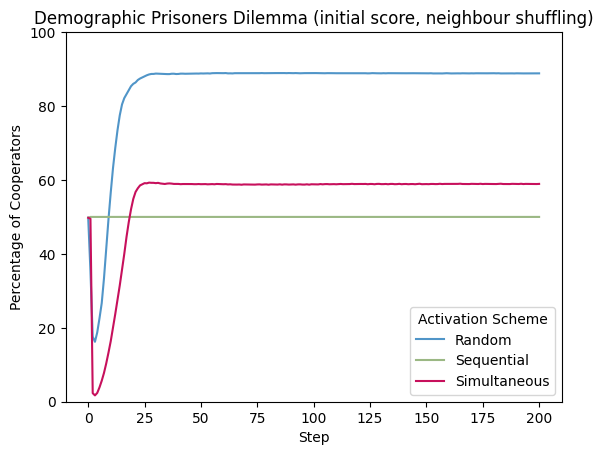

In [7]:
%matplotlib inline
simu = pd.DataFrame(results_simu)[['activation_order', 'Cooperating_Agents','Step']]
seq = pd.DataFrame(results_seq)[['activation_order', 'Cooperating_Agents','Step']]
ran = pd.DataFrame(results_ran)[['activation_order', 'Cooperating_Agents','Step']]

data = pd.concat([simu, seq, ran],axis=0)
data["Cooperating_Agents"] = data["Cooperating_Agents"]*100 / 30**2
df = data.groupby(['activation_order', 'Step']).agg("mean").reset_index()
df = pd.pivot(df, index="Step", columns="activation_order", values='Cooperating_Agents')
df.plot(use_index=True,colormap=uniks)
plt.xlabel('Step')
plt.ylabel('Percentage of Cooperators')
plt.ylim([0,100])
plt.title("Demographic Prisoners Dilemma (initial score, neighbour shuffling)")
plt.legend(title="Activation Scheme")
None

## With initial scoring and without shuffling of neighbours

In [8]:
results_simu_nos = batchrun_model(activation_order = "Simultaneous", initscores=True, shuffleneighbors=False)
results_seq_nos = batchrun_model(activation_order = "Sequential", initscores=True, shuffleneighbors=False)
results_ran_nos = batchrun_model(activation_order = "Random", initscores=True, shuffleneighbors=False)

/tmp/ipykernel_137994/3241259012.py:7: FutureWarning: The provided callable <function mean at 0x7019c83413a0> is currently using DataFrameGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  df = data.groupby(['activation_order', 'Step']).agg(np.mean).reset_index()


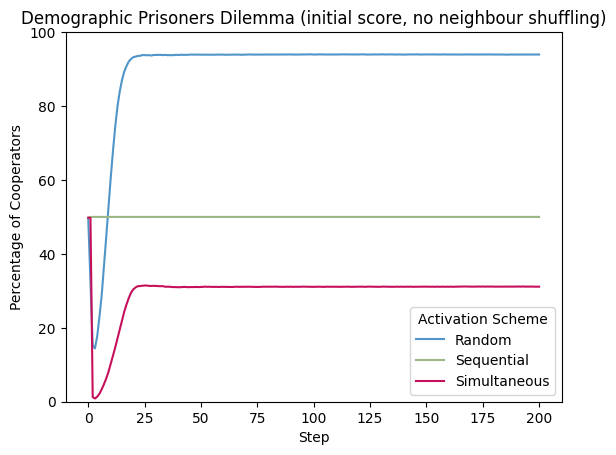

In [9]:
simu = pd.DataFrame(results_simu_nos)[['activation_order', 'Cooperating_Agents','Step']]
seq = pd.DataFrame(results_seq_nos)[['activation_order', 'Cooperating_Agents','Step']]
ran = pd.DataFrame(results_ran_nos)[['activation_order', 'Cooperating_Agents','Step']]

data = pd.concat([simu, seq, ran],axis=0)
data["Cooperating_Agents"] = data["Cooperating_Agents"]*100 / 30**2
df = data.groupby(['activation_order', 'Step']).agg(np.mean).reset_index()
df = pd.pivot(df, index="Step", columns="activation_order", values='Cooperating_Agents')
df.plot(use_index=True,colormap=uniks)
plt.xlabel('Step')
plt.ylabel('Percentage of Cooperators')
plt.ylim([0,100])
plt.title("Demographic Prisoners Dilemma (initial score, no neighbour shuffling)")
plt.legend(title="Activation Scheme")
None

## Without initial scoring and without shuffling of neighbours

In [10]:
results_simu_nosnos = batchrun_model(activation_order = "Simultaneous", initscores=False, shuffleneighbors=False)
results_seq_nosnos = batchrun_model(activation_order = "Sequential", initscores=False, shuffleneighbors=False)
results_ran_nosnos = batchrun_model(activation_order = "Random", initscores=False, shuffleneighbors=False)

/tmp/ipykernel_137994/3335551243.py:7: FutureWarning: The provided callable <function mean at 0x7019c83413a0> is currently using DataFrameGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  df = data.groupby(['activation_order', 'Step']).agg(np.mean).reset_index()


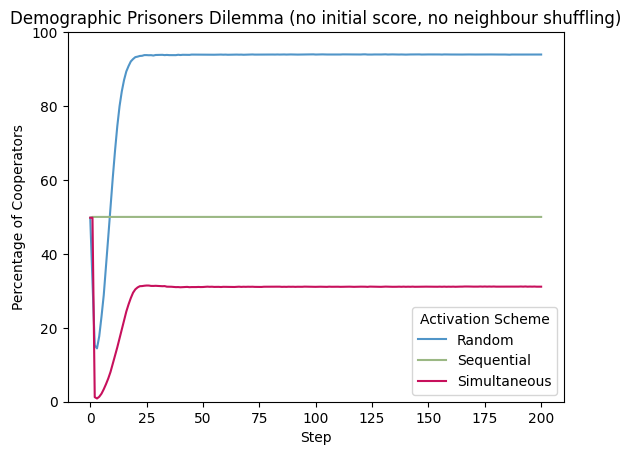

In [11]:
simu = pd.DataFrame(results_simu_nosnos)[['activation_order', 'Cooperating_Agents','Step']]
seq = pd.DataFrame(results_seq_nosnos)[['activation_order', 'Cooperating_Agents','Step']]
ran = pd.DataFrame(results_ran_nosnos)[['activation_order', 'Cooperating_Agents','Step']]

data = pd.concat([simu, seq, ran],axis=0)
data["Cooperating_Agents"] = data["Cooperating_Agents"]*100 / 30**2
df = data.groupby(['activation_order', 'Step']).agg(np.mean).reset_index()
df = pd.pivot(df, index="Step", columns="activation_order", values='Cooperating_Agents')
df.plot(use_index=True,colormap=uniks)
plt.xlabel('Step')
plt.ylim([0,100])
plt.ylabel('Percentage of Cooperators')
plt.title("Demographic Prisoners Dilemma (no initial score, no neighbour shuffling)")
plt.legend(title="Activation Scheme")
None

In [21]:
def compare_runs(models):
    data = pd.DataFrame()
    for model in models:
        modeldata = model.datacollector.get_model_vars_dataframe() * 100 / len(model.agents)
        modeldata.columns = [model.activation_order]
        data = pd.concat([data, modeldata],axis=1)

    #fig = plt.figure(figsize=(12, 8))
    fig = plt.figure()
    ax1 = fig.add_subplot(111)
    data.plot(ax=ax1, colormap=uniks)
    plt.xlabel('Step')
    plt.ylabel('Percentage of Cooperators')
    plt.title("Demographic Prisoners Dilemma (single runs)")
    plt.legend(title="Activation Scheme")
    fig.savefig("dpd_compare.png")

## Set the random seed

In [13]:
seed = 22

## Sequential Activation

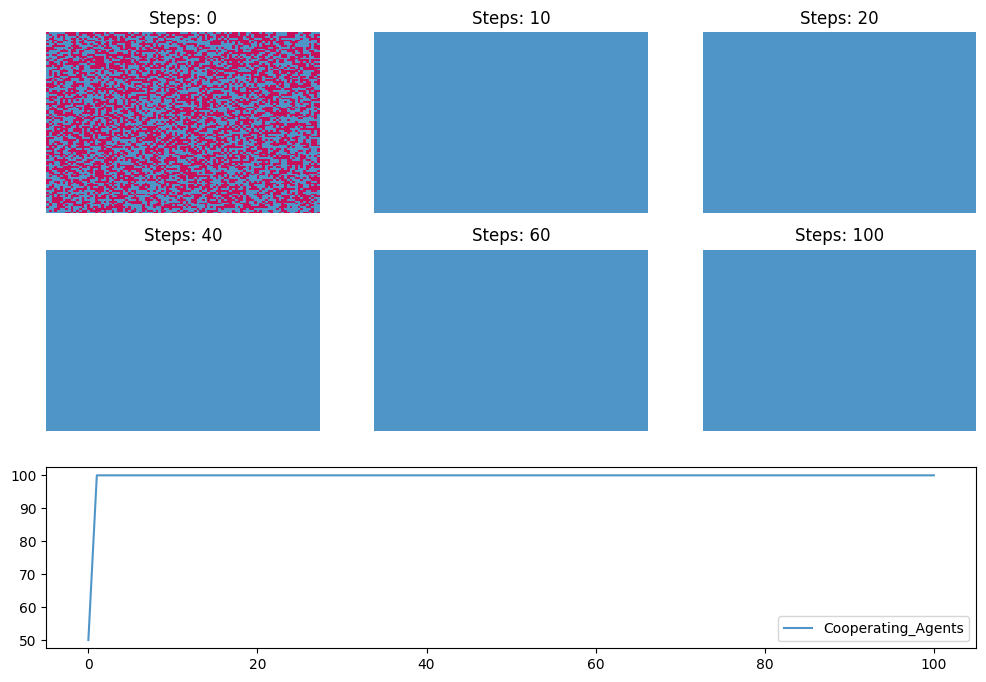

In [14]:
m_sequential = PdGrid(100, 100, "Sequential", seed=seed, initscores=True)
run_model(m_sequential)

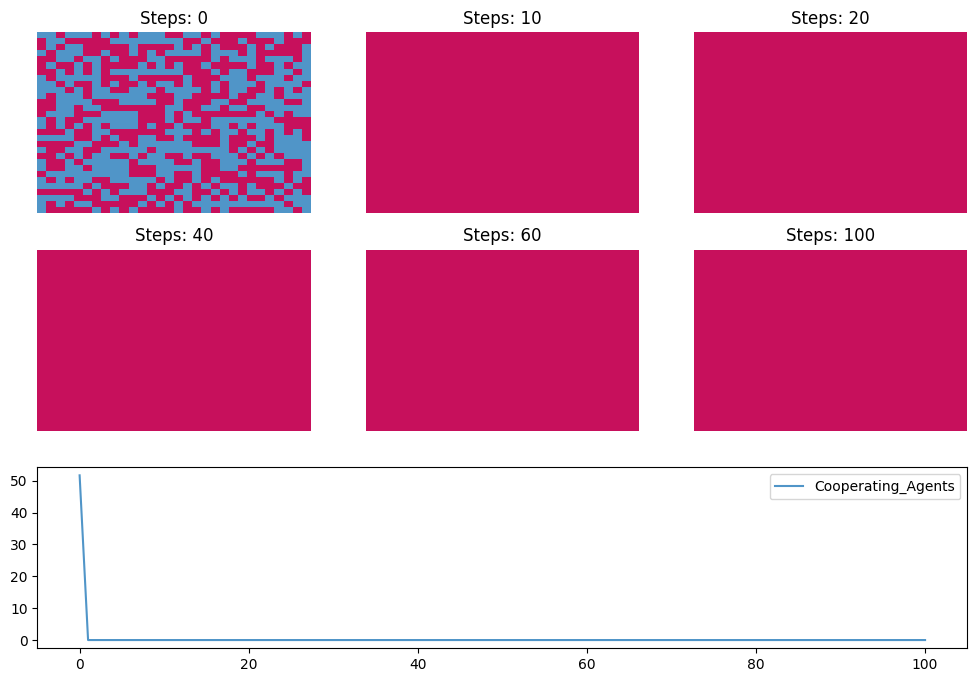

In [15]:
m_sequential = PdGrid(30, 30, "Sequential", seed=seed, initscores=False)
run_model(m_sequential)

## Random Activation

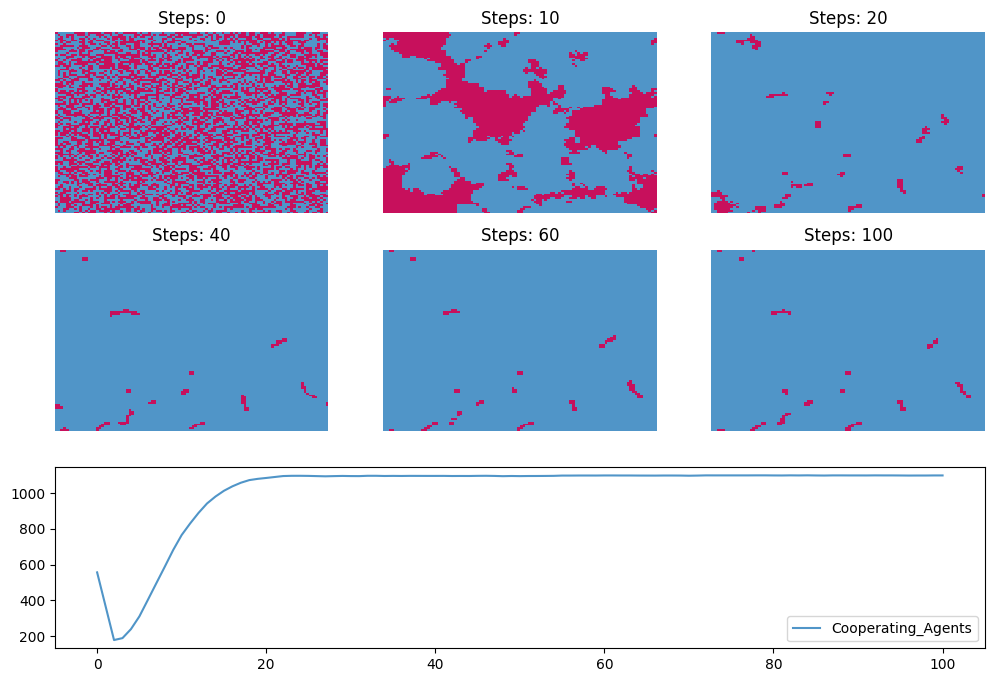

In [16]:
m_random = PdGrid(100, 100, "Random", seed=seed, initscores=True)
run_model(m_random)

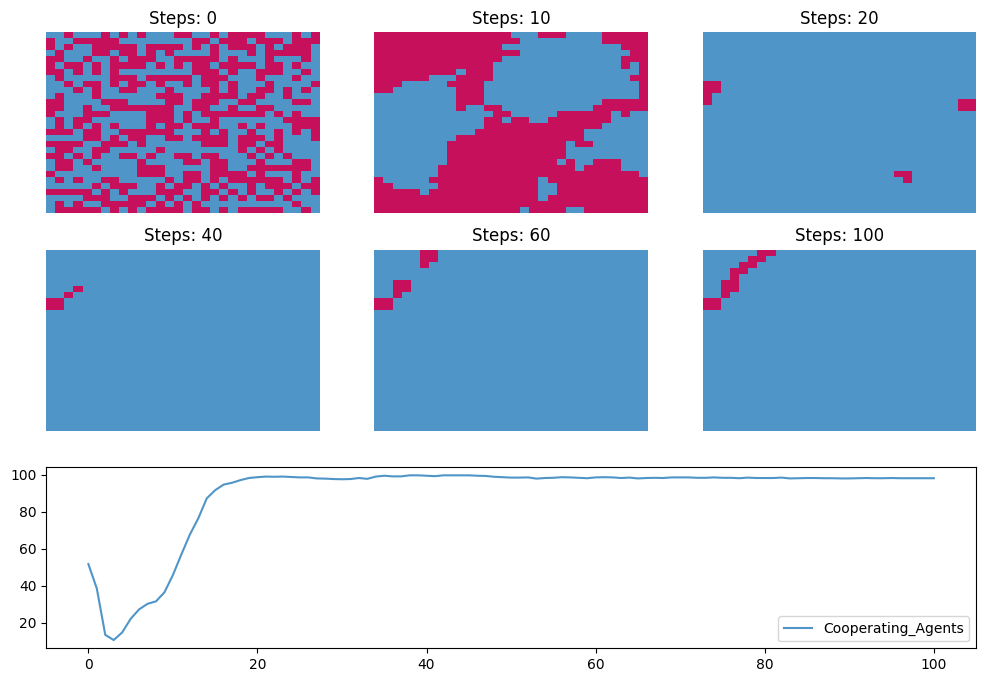

In [17]:
m_random = PdGrid(30, 30, "Random", seed=seed, initscores=False)
run_model(m_random)

## Simultaneous Activation

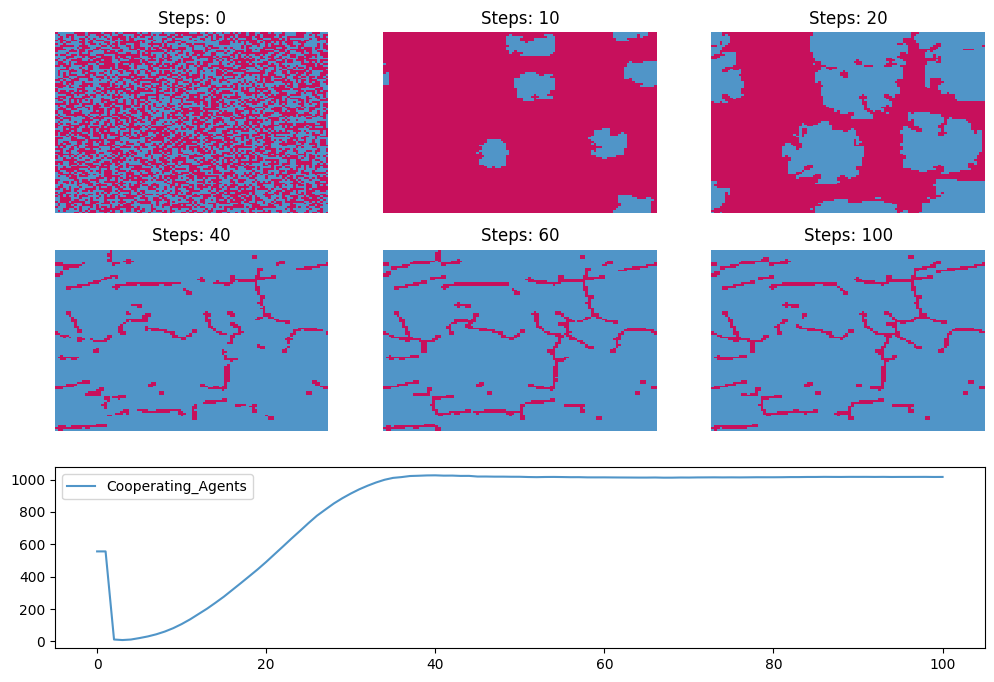

In [18]:
m_simultaneous = PdGrid(100, 100, "Simultaneous", seed=seed, initscores = True)
run_model(m_simultaneous)

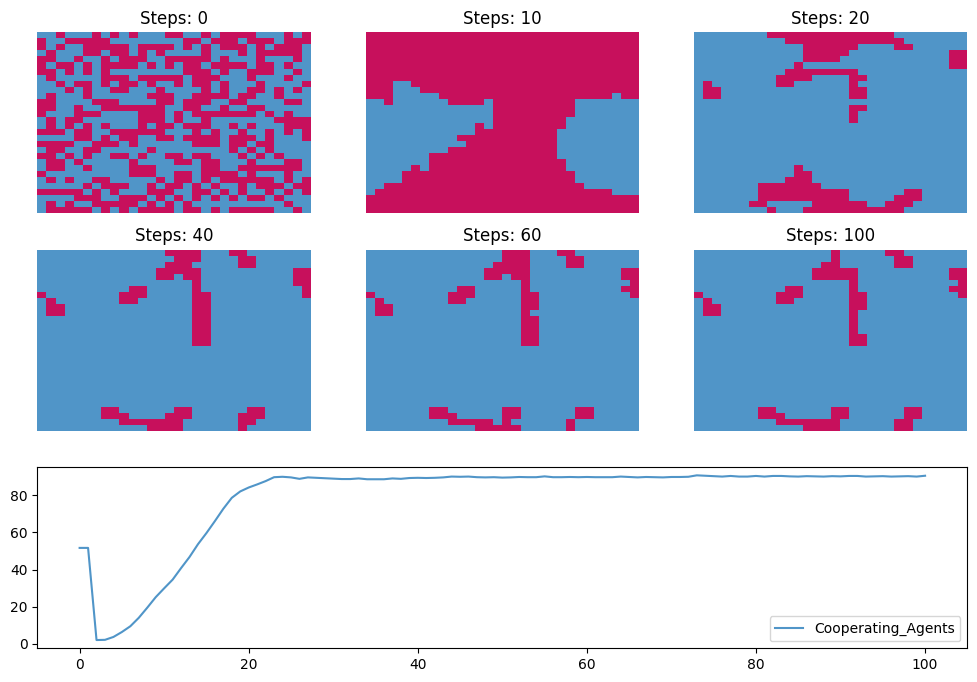

In [19]:
m_simultaneous = PdGrid(30, 30, "Simultaneous", seed=seed, initscores = False)
run_model(m_simultaneous)

## Compare runs

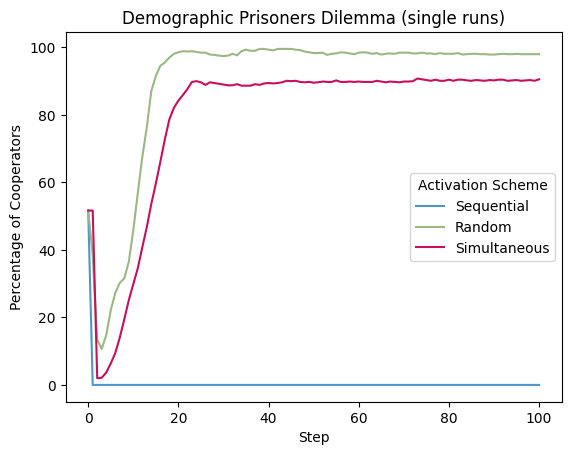

In [22]:
matplotlib.rcParams['font.size'] = 10
compare_runs([m_sequential, m_random, m_simultaneous])

## Warm-up: Random activation

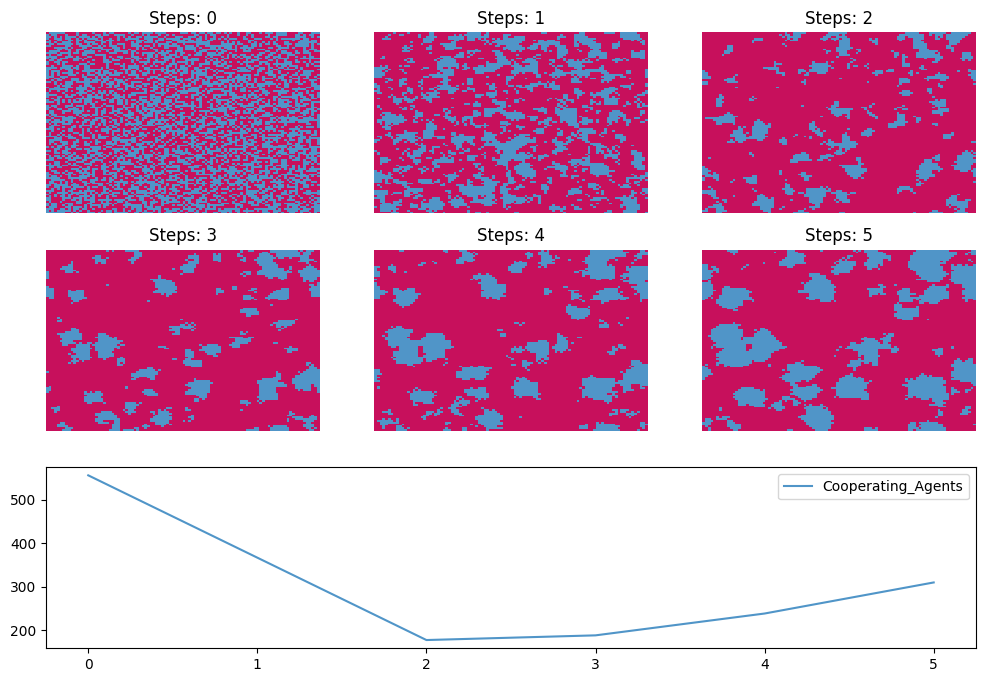

In [23]:
m_random = PdGrid(100, 100, "Random", seed=seed)
run_model(m_random, steps = [1,1,1,1,1])

## Warm-up: Simultaneous Activation

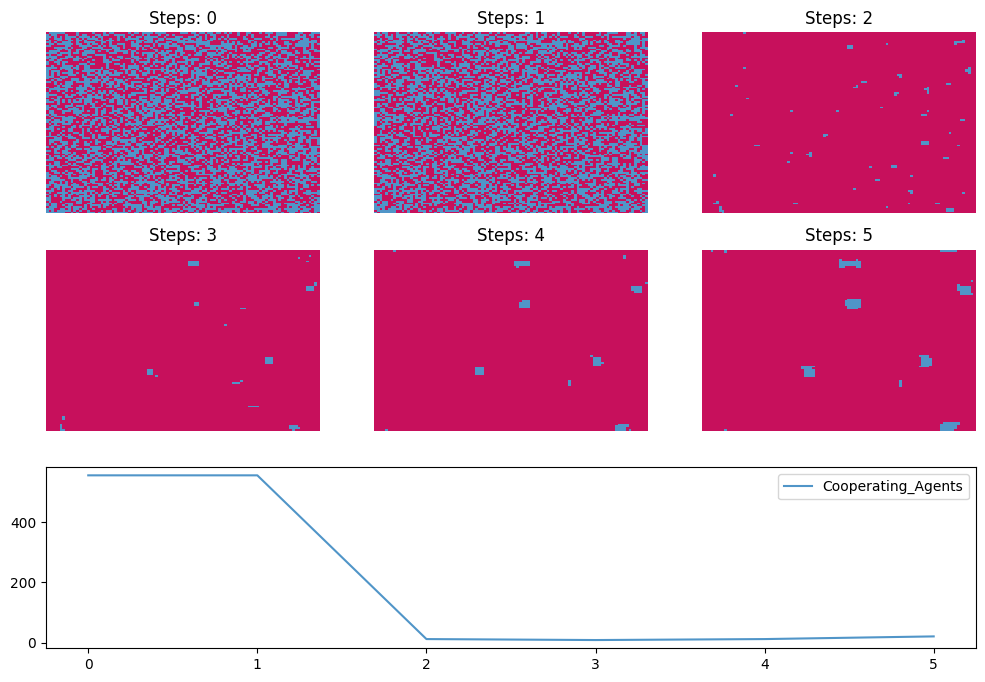

In [24]:
m_simultaneous = PdGrid(100, 100, "Simultaneous", seed=seed)
run_model(m_simultaneous, steps = [1,1,1,1,1])

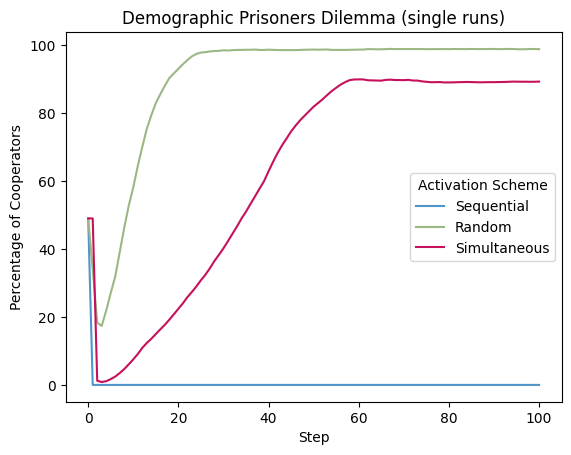

In [25]:
seed = 31
m_sequential = PdGrid(100, 100, "Sequential", seed=seed)
run_model(m_sequential, showfigures=False)
m_random = PdGrid(100, 100, "Random", seed=seed)
run_model(m_random, showfigures=False)
m_simultaneous = PdGrid(100, 100, "Simultaneous", seed=seed)
run_model(m_simultaneous, showfigures=False)
compare_runs([m_sequential, m_random, m_simultaneous])